<a href="https://colab.research.google.com/github/Vladimir-coder-sys/Yurchak.VA/blob/main/%D0%A0%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D0%B5%20%D1%82%D0%B5%D1%81%D1%82%D0%BE%D0%B2%D0%BE%D0%B3%D0%BE%20%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Решение тестового задания

Скачивание необходимых библиотек

In [ ]:
!pip install torch torchvision pandas numpy matplotlib seaborn scikit-learn pillow kagglehub

Импорт необходимых библиотек

In [ ]:
# Импорт необходимых библиотек
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, classification_report
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import warnings
warnings.filterwarnings('ignore')

Загрузка датасета

In [ ]:
# Загрузка датасета
!pip install kagglehub

In [ ]:
import kagglehub

# Скачивание датасета
path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-dataset")
print("Path to dataset files:", path)

100%|██████████| 23.1G/23.1G [04:41<00:00, 88.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-dataset/versions/1


In [ ]:
# Загрузка метаданных
df = pd.read_csv(os.path.join('/root/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-dataset/versions/1/fashion-dataset/styles.csv'), on_bad_lines='skip')
print(f"Dataset shape: {df.shape}")

Dataset shape: (44424, 10)


Предварительный анализ данных

In [ ]:
# Предварительный просмотр данных
print(df.head())
print(df.info())

      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 10 columns):
 #   Column         

Процедура очистки данных

In [ ]:
# Очистка данных и заполнение пропущенных значений
print("Пропущенные значения до обработки:")
print(df.isnull().sum())

Пропущенные значения до обработки:
id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
dtype: int64


Заполнение пропущенных значений в числовых и категориальных столбцах данных

In [ ]:
# Заполнение пропусков в числовых столбцах медианными значениями
numerical_cols = ['year']
for col in numerical_cols:
    if col in df.columns:
        median_value = df[col].median()
        df[col].fillna(median_value, inplace=True)
        print(f"Заполнено пропусков в {col}: {df[col].isnull().sum()} значением {median_value}")


Заполнено пропусков в year: 0 значением 2012.0


In [ ]:
# Заполнение пропусков в категориальных столбцах модой (наиболее частым значением)
categorical_cols = ['productDisplayName', 'masterCategory', 'subCategory',
                   'articleType', 'baseColour', 'season', 'usage','gender','id']

In [ ]:
for col in categorical_cols:
    if col in df.columns:
        mode_value = df[col].mode()[0] if not df[col].mode().empty else 'Unknown'
        df[col].fillna(mode_value, inplace=True)
        print(f"Заполнено пропусков в {col}: {df[col].isnull().sum()} значением '{mode_value}'")

Заполнено пропусков в productDisplayName: 0 значением 'Lucera Women Silver Earrings'
Заполнено пропусков в masterCategory: 0 значением 'Apparel'
Заполнено пропусков в subCategory: 0 значением 'Topwear'
Заполнено пропусков в articleType: 0 значением 'Tshirts'
Заполнено пропусков в baseColour: 0 значением 'Black'
Заполнено пропусков в season: 0 значением 'Summer'
Заполнено пропусков в usage: 0 значением 'Casual'
Заполнено пропусков в gender: 0 значением 'Men'
Заполнено пропусков в id: 0 значением '1163'


In [ ]:
# Для столбца с отзывами необходимо заполнить нулями или медианой
if 'reviews' in df.columns:
    df['reviews'].fillna(0, inplace=True)

Финальная проверка после обработки

In [ ]:
print("Пропущенные значения после обработки:")
print(df.isnull().sum())

Пропущенные значения после обработки:
id                    0
gender                0
masterCategory        0
subCategory           0
articleType           0
baseColour            0
season                0
year                  0
usage                 0
productDisplayName    0
dtype: int64


Создание прокси-метрики «успешности товара» (топ-20% товаров)

In [ ]:
# Создаем фиктивный показатель "популярности" на основе имеющихся данных
if 'year' in df.columns and 'masterCategory' in df.columns:
    # Нормализуем числовой признак (год)
    scaler = StandardScaler()
    df['year_norm'] = scaler.fit_transform(df[['year']])

    # Преобразуем категориальные признаки в числовые (частотное кодирование)
    # Для masterCategory
    category_freq = df['masterCategory'].value_counts(normalize=True)
    df['category_norm'] = df['masterCategory'].map(category_freq)

    # Для subCategory (если доступен)
    if 'subCategory' in df.columns:
        subcategory_freq = df['subCategory'].value_counts(normalize=True)
        df['subcategory_norm'] = df['subCategory'].map(subcategory_freq)

    # Для articleType (если доступен)
    if 'articleType' in df.columns:
        article_freq = df['articleType'].value_counts(normalize=True)
        df['article_norm'] = df['articleType'].map(article_freq)

    # Для season (если доступен) - предположим, что текущий сезон более популярен
    if 'season' in df.columns:
        # Создаем словарь для кодирования сезонов (условные веса)
        season_weights = {'Fall': 0.8, 'Winter': 0.9, 'Spring': 0.7, 'Summer': 0.6, 'All-Season': 0.5}
        df['season_norm'] = df['season'].map(lambda x: season_weights.get(x, 0.5))

    # Нормализуем все созданные признаки
    features_to_normalize = ['category_norm']
    if 'subcategory_norm' in df.columns:
        features_to_normalize.append('subcategory_norm')
    if 'article_norm' in df.columns:
        features_to_normalize.append('article_norm')
    if 'season_norm' in df.columns:
        features_to_normalize.append('season_norm')

    for feature in features_to_normalize:
        df[feature] = scaler.fit_transform(df[[feature]])

    # Создаем составной показатель с настраиваемыми весами
    # Базовые веса (можно настроить)
    weights = {
        'year': 0.4,
        'category': 0.3,
        'subcategory': 0.15,
        'article': 0.1,
        'season': 0.05
    }

    # Инициализируем composite_score
    df['composite_score'] = df['year_norm'] * weights['year']

    # Добавляем остальные компоненты, если они доступны
    if 'category_norm' in df.columns:
        df['composite_score'] += df['category_norm'] * weights['category']

    if 'subcategory_norm' in df.columns:
        df['composite_score'] += df['subcategory_norm'] * weights['subcategory']

    if 'article_norm' in df.columns:
        df['composite_score'] += df['article_norm'] * weights['article']

    if 'season_norm' in df.columns:
        df['composite_score'] += df['season_norm'] * weights['season']

    # Находим топ-20% по составному показателю
    threshold = df['composite_score'].quantile(0.8)
    df['target'] = (df['composite_score'] >= threshold).astype(int)

    print(f"Target distribution based on composite score:\n{df['target'].value_counts()}")
    print(f"Percentage of successful products: {df['target'].mean()*100:.2f}%")

    # Дополнительный анализ: посмотрим, какие категории чаще встречаются среди успешных товаров
    successful_by_category = df.groupby('masterCategory')['target'].mean().sort_values(ascending=False)
    print("\nДоля успешных товаров по категориям:")
    print(successful_by_category)

    # Анализ по другим признакам
    if 'subCategory' in df.columns:
        successful_by_subcategory = df.groupby('subCategory')['target'].mean().sort_values(ascending=False)
        print("\nДоля успешных товаров по подкатегориям (топ-10):")
        print(successful_by_subcategory.head(10))

    if 'season' in df.columns:
        successful_by_season = df.groupby('season')['target'].mean().sort_values(ascending=False)
        print("\nДоля успешных товаров по сезонам:")
        print(successful_by_season)

Target distribution based on composite score:
target
0    34501
1     9923
Name: count, dtype: int64
Percentage of successful products: 22.34%

Доля успешных товаров по категориям:
masterCategory
Apparel           0.328971
Accessories       0.225475
Footwear          0.037097
Free Items        0.000000
Home              0.000000
Personal Care     0.000000
Sporting Goods    0.000000
Name: target, dtype: float64

Доля успешных товаров по подкатегориям (топ-10):
subCategory
Watches                     0.996459
Loungewear and Nightwear    0.936170
Innerwear                   0.877765
Topwear                     0.318335
Sandal                      0.061267
Bottomwear                  0.039718
Shoes                       0.038404
Apparel Set                 0.009434
Bags                        0.002946
Saree                       0.002342
Name: target, dtype: float64

Доля успешных товаров по сезонам:
season
Winter    0.415757
Fall      0.201995
Summer    0.187410
Spring    0.015085
Name: t

Вывод итогового Dataframe

In [ ]:
df

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,year_norm,category_norm,subcategory_norm,article_norm,season_norm,composite_score,target
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,-0.849534,0.986048,1.290118,0.415676,0.692199,0.225696,0
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,-0.379263,0.986048,-0.742664,-0.723198,-0.949916,-0.087106,0
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,1.501819,-0.627424,-0.766978,0.120914,1.513256,0.385208,1
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,-0.849534,0.986048,-0.742664,-0.856387,0.692199,-0.206427,0
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,-0.379263,0.986048,1.290118,2.096913,-0.949916,0.499822,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe,0.091007,-0.954963,0.000994,0.253229,-0.949916,-0.272110,0
44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop,-0.849534,-0.954963,-1.027554,-0.590009,-0.949916,-0.886932,0
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt,-0.849534,0.986048,1.290118,2.096913,0.692199,0.393820,1
44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume,1.972089,-2.041343,-1.011878,-0.721451,-0.128859,-0.053937,0


Создание и обработка датасета с изображениями товаров

In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import multiprocessing
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Проверяем доступность GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

# Создаем датасет для эффективной загрузки изображений
class FashionDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            image = Image.open(self.image_paths[idx]).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image
        except Exception as e:
            print(f"Ошибка загрузки {self.image_paths[idx]}: {str(e)}")
            # Возвращаем пустой тензор в случае ошибки
            return torch.zeros(3, 224, 224)

# Класс для извлечения признаков с использованием батчей
class BatchImageFeatureExtractor:
    def __init__(self, batch_size=32):
        self.batch_size = batch_size
        self.model = models.resnet50(pretrained=True)
        self.model = torch.nn.Sequential(*list(self.model.children())[:-1])
        self.model = self.model.to(device)
        self.model.eval()

        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def extract_features_batch(self, image_paths):
        """Извлекает признаки для батча изображений"""
        dataset = FashionDataset(image_paths, self.transform)
        dataloader = DataLoader(dataset, batch_size=self.batch_size,
                               num_workers=multiprocessing.cpu_count(),
                               pin_memory=True)

        features_list = []
        valid_indices = []

        with torch.no_grad():
            for i, batch in enumerate(tqdm(dataloader, desc="Извлечение признаков")):
                batch = batch.to(device)
                features = self.model(batch)
                features = features.squeeze().cpu().numpy()

                # Обрабатываем случай, когда батч состоит из одного изображения
                if len(features.shape) == 1:
                    features = features.reshape(1, -1)

                features_list.append(features)

                # Сохраняем индексы валидных изображений
                batch_start_idx = i * self.batch_size
                batch_end_idx = min((i + 1) * self.batch_size, len(image_paths))
                valid_indices.extend(range(batch_start_idx, batch_end_idx))

        # Объединяем все признаки в один массив
        all_features = np.vstack(features_list)
        return all_features, valid_indices

# Сначала найдем все существующие изображения
images_dir = '/root/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-dataset/versions/1/fashion-dataset/images'
print("Поиск изображений...")

# Создаем список путей к существующим изображениям и соответствующих индексов
image_paths = []
valid_indices = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Проверка изображений"):
    image_path = os.path.join(images_dir, f"{row['id']}.jpg")
    if os.path.exists(image_path):
        image_paths.append(image_path)
        valid_indices.append(idx)

print(f"Найдено {len(image_paths)} существующих изображений")

# Извлекаем признаки батчами
extractor = BatchImageFeatureExtractor(batch_size=64)
image_features, batch_valid_indices = extractor.extract_features_batch(image_paths)

# Фильтрация DataFrame по валидным индексам
df_valid = df.loc[valid_indices].reset_index(drop=True)

# Убедимся, что размеры совпадают
assert len(df_valid) == len(image_features), "Размеры DataFrame и признаков не совпадают"

Используемое устройство: cpu
Поиск изображений...


Проверка изображений: 100%|██████████| 44424/44424 [00:03<00:00, 11961.16it/s]


Найдено 44419 существующих изображений


Извлечение признаков: 100%|██████████| 695/695 [3:44:19<00:00, 19.37s/it]


Кодирование категориальных признаков по Dataframe изображений

In [ ]:
# Подготовка табличных признаков
categorical_cols = ['masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'usage', 'gender','productDisplayName']
numerical_cols = ['year']

In [ ]:
# Кодирование категориальных признаков
label_encoders = {}
X_tabular = pd.DataFrame()

for col in categorical_cols:
    if col in df_valid.columns:
        le = LabelEncoder()
        X_tabular[col] = le.fit_transform(df_valid[col].astype(str))
        label_encoders[col] = le

# Добавление числовых признаков
for col in numerical_cols:
    if col in df_valid.columns:
        X_tabular[col] = df_valid[col]

# Нормализация числовых признаков
if numerical_cols:
    scaler = StandardScaler()
    X_tabular[numerical_cols] = scaler.fit_transform(X_tabular[numerical_cols])

Присвоение целевой переменной и обучение модели

In [ ]:
# Целевая переменная
y = df_valid['target'].values

# Разделение на тренировочную и тестовую выборки
X_tabular_train, X_tabular_test, X_image_train, X_image_test, y_train, y_test = train_test_split(
    X_tabular, image_features, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# Обучение моделей с использованием всех ядер
n_jobs = multiprocessing.cpu_count()

In [ ]:
# 1. Только табличные данные
rf_tabular = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=n_jobs)
rf_tabular.fit(X_tabular_train, y_train)
y_pred_tabular = rf_tabular.predict_proba(X_tabular_test)[:, 1]

In [ ]:
# 2. Только изображения
rf_image = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=n_jobs)
rf_image.fit(X_image_train, y_train)
y_pred_image = rf_image.predict_proba(X_image_test)[:, 1]

In [ ]:
# 3. Комбинированные признаки
X_combined_train = np.hstack([X_tabular_train, X_image_train])
X_combined_test = np.hstack([X_tabular_test, X_image_test])

rf_combined = RandomForestClassifier(n_estimators=100, random_state=42)
rf_combined.fit(X_combined_train, y_train)
y_pred_combined = rf_combined.predict_proba(X_combined_test)[:, 1]

Оценка качества построенной модели

In [ ]:
# Оценка моделей
print("Только табличные данные:")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_tabular):.4f}")
print(f"F1-Score: {f1_score(y_test, (y_pred_tabular > 0.5).astype(int)):.4f}")

print("\nТолько изображения:")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_image):.4f}")
print(f"F1-Score: {f1_score(y_test, (y_pred_image > 0.5).astype(int)):.4f}")

print("\nКомбинированные признаки:")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_combined):.4f}")
print(f"F1-Score: {f1_score(y_test, (y_pred_combined > 0.5).astype(int)):.4f}")

Только табличные данные:
ROC-AUC: 1.0000
F1-Score: 0.9997

Только изображения:
ROC-AUC: 0.9658
F1-Score: 0.8068

Комбинированные признаки:
ROC-AUC: 0.9863
F1-Score: 0.8570


Вывод статистики по каждому кластеру

In [ ]:
# Кластеризация эмбеддингов
pca = PCA(n_components=50)
image_features_reduced = pca.fit_transform(image_features)

kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(image_features_reduced)

# Анализ кластеров
cluster_analysis = pd.DataFrame({
    'cluster': clusters,
    'target': df_valid['target'].values,
    'masterCategory': df_valid['masterCategory'].values,
    'subCategory': df_valid['subCategory'].values,
    'articleType': df_valid['articleType'].values
})

# Находим наиболее частую категорию для каждого кластера по каждому типу
cluster_modes = (
    cluster_analysis
    .groupby('cluster')[['masterCategory', 'subCategory', 'articleType']]
    .agg(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'Unknown')
)

# Создаем составные имена кластеров
cluster_names = {}
for cluster_num in cluster_modes.index:
    master = cluster_modes.loc[cluster_num, 'masterCategory']
    sub = cluster_modes.loc[cluster_num, 'subCategory']
    article = cluster_modes.loc[cluster_num, 'articleType']
    cluster_names[cluster_num] = f"{master}_{sub}_{article}"

# Добавляем именованные метки кластеров
cluster_analysis['cluster_name'] = cluster_analysis['cluster'].map(cluster_names)

# Выводим результаты
print("Соответствие кластеров категориям:")
for cluster_num, category_name in cluster_names.items():
    print(f"Кластер {cluster_num}: {category_name}")

# Показываем первые несколько строк для проверки
print("\nПервые несколько записей:")
print(cluster_analysis[['cluster', 'cluster_name', 'target', 'masterCategory', 'subCategory', 'articleType']].head())

# Альтернативный вариант с группировкой
cluster_distribution_alt = cluster_analysis.groupby(['cluster_name', 'masterCategory']).size().unstack(fill_value=0)
print("\nРаспределение категорий по кластерам (альтернативный метод):")
print(cluster_distribution_alt)

Соответствие кластеров категориям:
Кластер 0: Apparel_Topwear_Shirts
Кластер 1: Apparel_Topwear_Tshirts
Кластер 2: Accessories_Eyewear_Sunglasses
Кластер 3: Footwear_Shoes_Heels
Кластер 4: Accessories_Bags_Handbags
Кластер 5: Accessories_Watches_Watches
Кластер 6: Apparel_Topwear_Kurtas
Кластер 7: Personal Care_Fragrance_Perfume and Body Mist
Кластер 8: Footwear_Shoes_Casual Shoes
Кластер 9: Footwear_Shoes_Sports Shoes

Первые несколько записей:
   cluster                 cluster_name  target masterCategory subCategory  \
0        1      Apparel_Topwear_Tshirts       0        Apparel     Topwear   
1        0       Apparel_Topwear_Shirts       0        Apparel  Bottomwear   
2        5  Accessories_Watches_Watches       1    Accessories     Watches   
3        0       Apparel_Topwear_Shirts       0        Apparel  Bottomwear   
4        1      Apparel_Topwear_Tshirts       1        Apparel     Topwear   

   articleType  
0       Shirts  
1        Jeans  
2      Watches  
3  Track Pant

Визуализация статистики по доле успешных товаров по кластерам

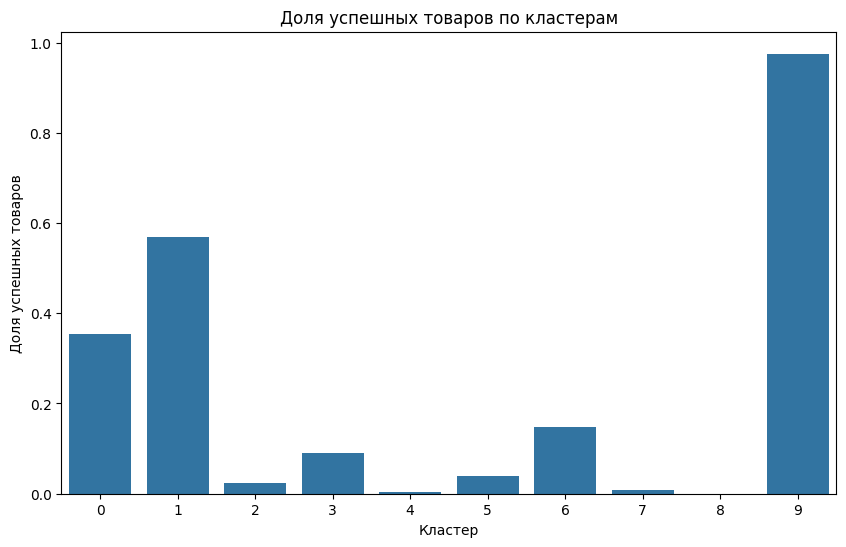

In [ ]:
# Визуализация кластеров
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_stats.index, y=cluster_stats['mean'])
plt.title('Доля успешных товаров по кластерам')
plt.xlabel('Кластер')
plt.ylabel('Доля успешных товаров')
plt.show()

In [ ]:
# Анализ особенностей успешных кластеров
successful_clusters = cluster_stats[cluster_stats['mean'] > cluster_stats['mean'].mean()].index

In [ ]:
# Выборка изображений из успешных кластеров
successful_images = []
for cluster_id in successful_clusters:
    cluster_indices = np.where(clusters == cluster_id)[0]
    sample_indices = np.random.choice(cluster_indices, size=min(5, len(cluster_indices)), replace=False)

    for idx in sample_indices:
        image_path = os.path.join(images_dir, f"{df_valid.iloc[idx]['id']}.jpg")
        successful_images.append({
            'cluster': cluster_id,
            'image_path': image_path,
            'success_rate': cluster_stats.loc[cluster_id, 'mean']
        })

Визуализация успешных изображений товаров (топ-9 товаров)

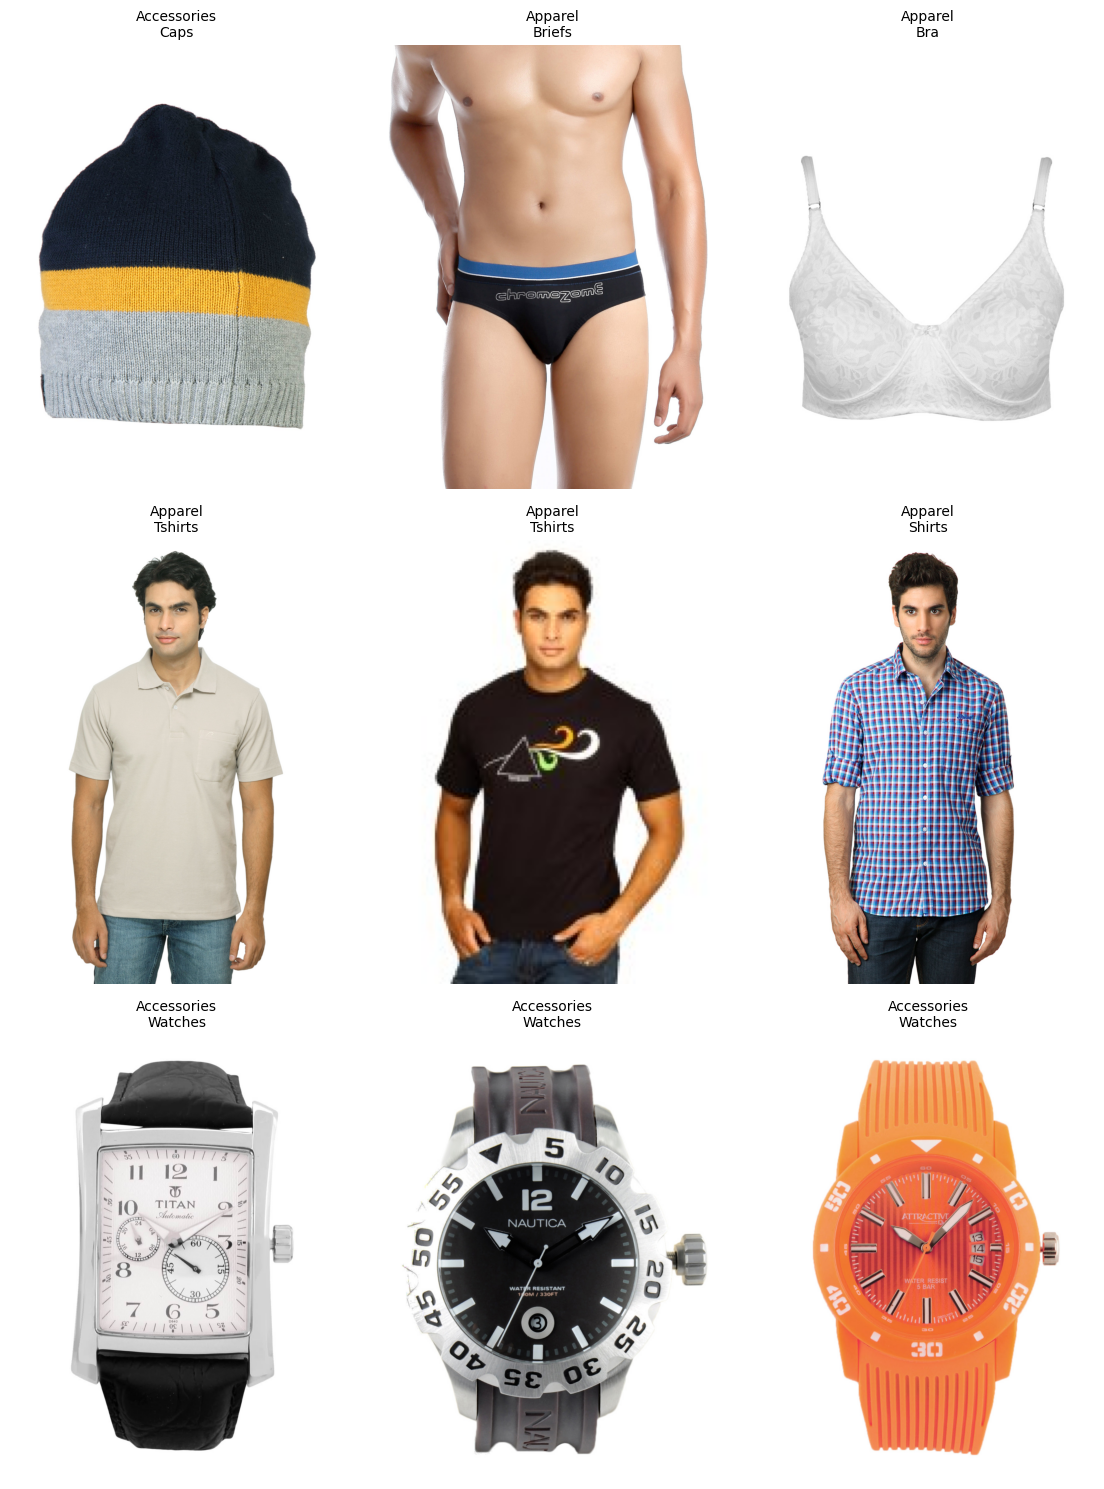


Описание кластеров:
   Кластер                                           Описание  Успешность  \
9        9  Cluster 9: Accessories:2467 | Free Items:45 | ...    0.975328   
1        1  Cluster 1: Apparel:8029 | Footwear:3 | Accesso...    0.569562   
0        0  Cluster 0: Apparel:1707 | Accessories:1114 | F...    0.354453   
6        6  Cluster 6: Apparel:5727 | Accessories:141 | Fr...    0.148532   
3        3  Cluster 3: Apparel:5834 | Accessories:32 | Foo...    0.091327   
5        5           Cluster 5: Footwear:8901 | Accessories:6    0.038284   
2        2  Cluster 2: Accessories:3680 | Footwear:294 | P...    0.023721   
7        7  Cluster 7: Personal Care:2193 | Accessories:74...    0.007916   
4        4  Cluster 4: Accessories:2682 | Apparel:11 | Fre...    0.004440   
8        8  Cluster 8: Accessories:1075 | Free Items:8 | A...    0.000000   

   Размер  
9    2513  
1    8036  
0    2841  
6    5891  
3    5869  
5    8907  
2    4300  
7    2274  
4    2703  
8    1085  

In [ ]:
# Сначала проанализируем визуальные характеристики каждого кластера
from collections import Counter

# Создаем DataFrame для анализа кластеров
cluster_analysis = pd.DataFrame({
    'cluster': clusters,
    'target': df_valid['target'].values
})

# Добавляем информацию о категориях товаров
cluster_analysis['category'] = df_valid['masterCategory'].values

# Анализируем каждый кластер
cluster_descriptions = {}
for cluster_id in np.unique(clusters):
    cluster_data = cluster_analysis[cluster_analysis['cluster'] == cluster_id]

    # Находим наиболее частые категории в кластере
    top_categories = cluster_data['category'].value_counts().head(3)
    category_desc = " | ".join([f"{cat}:{count}" for cat, count in top_categories.items()])

    # Анализируем успешность
    success_rate = cluster_data['target'].mean()

    # Формируем описание кластера
    cluster_descriptions[cluster_id] = {
        'description': f"Cluster {cluster_id}: {category_desc}",
        'success_rate': success_rate,
        'size': len(cluster_data)
    }

# Визуализация примеров успешных изображений с описаниями кластеров
successful_clusters = [k for k, v in cluster_descriptions.items() if v['success_rate'] > cluster_analysis['target'].mean()]

# Выбираем по 5 изображения из каждого успешного кластера
fig, axes = plt.subplots(len(successful_clusters), 3, figsize=(15, 5*len(successful_clusters)))

# Если только один кластер, axes будет 1D, преобразуем в 2D
if len(successful_clusters) == 1:
    axes = axes.reshape(1, -1)

for i, cluster_id in enumerate(successful_clusters):
    cluster_indices = np.where(clusters == cluster_id)[0]
    sample_indices = np.random.choice(cluster_indices, size=min(3, len(cluster_indices)), replace=False)

    for j, idx in enumerate(sample_indices):
        try:
            image_path = os.path.join(images_dir, f"{df_valid.iloc[idx]['id']}.jpg")
            img = Image.open(image_path)

            # Отображаем изображение
            axes[i, j].imshow(img)

            # Добавляем информацию о товаре
            product_info = f"{df_valid.iloc[idx]['masterCategory']}\n{df_valid.iloc[idx]['articleType']}"
            axes[i, j].set_title(product_info, fontsize=10)
            axes[i, j].axis('off')

        except Exception as e:
            print(f"Ошибка загрузки изображения: {e}")
            axes[i, j].axis('off')

    # Добавляем описание кластера слева от изображений
    if j == 0:  # Только для первого столбца
        desc = cluster_descriptions[cluster_id]['description']
        success = cluster_descriptions[cluster_id]['success_rate']
        size = cluster_descriptions[cluster_id]['size']

        # Создаем текстовое описание
        cluster_text = f"{desc}\nУспешность: {success:.2f}\nРазмер: {size}"
        axes[i, 0].text(-0.5, 0.5, cluster_text, transform=axes[i, 0].transAxes,
                       fontsize=12, verticalalignment='center',
                       bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))

plt.tight_layout()
plt.subplots_adjust(left=0.2)  # Оставляем место для описаний кластеров
plt.show()

# Дополнительно: выводим таблицу с описанием всех кластеров
cluster_summary = []
for cluster_id, info in cluster_descriptions.items():
    cluster_summary.append({
        'Кластер': cluster_id,
        'Описание': info['description'],
        'Успешность': info['success_rate'],
        'Размер': info['size']
    })

cluster_summary_df = pd.DataFrame(cluster_summary)
print("\nОписание кластеров:")
print(cluster_summary_df.sort_values('Успешность', ascending=False))

Анализ важности табличных и визуальных признаков

In [ ]:
# Анализ важности признаков для комбинированной модели
feature_importances = rf_combined.feature_importances_
tabular_importance = sum(feature_importances[:X_tabular.shape[1]])
image_importance = sum(feature_importances[X_tabular.shape[1]:])

print(f"\nВажность табличных признаков: {tabular_importance:.4f}")
print(f"Важность визуальных признаков: {image_importance:.4f}")


Важность табличных признаков: 0.0776
Важность визуальных признаков: 0.9224


Вывод анализа по категориям товаров

In [ ]:
# Сначала получим предсказания для всех данных
X_combined = np.hstack([X_tabular, image_features])
y_pred_full = rf_combined.predict_proba(X_combined)[:, 1]

# Создаем DataFrame с предсказаниями для всех записей
full_results = pd.DataFrame({
    'true_label': y,
    'predicted_prob': y_pred_full,
    'masterCategory': df_valid['masterCategory'].values
})

# Анализ по категориям товаров
category_results = []
for category in full_results['masterCategory'].unique():
    category_data = full_results[full_results['masterCategory'] == category]
    if len(category_data) > 1:
        category_roc = roc_auc_score(category_data['true_label'], category_data['predicted_prob'])
        category_results.append({
            'category': category,
            'samples': len(category_data),
            'roc_auc': category_roc
        })

category_df = pd.DataFrame(category_results)
print("\nРезультаты по категориям (на всех данных):")
print(category_df.sort_values('roc_auc', ascending=False))


Результаты по категориям (на всех данных):
         category  samples   roc_auc
1     Accessories    11274  0.999992
2        Footwear     9219  0.999850
0         Apparel    21392  0.997869
3   Personal Care     2403       NaN
4      Free Items      105       NaN
5  Sporting Goods       25       NaN
